In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [7]:
from torchvision import datasets, transforms

cifar10 = datasets.CIFAR10(
    '.', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [8]:
cifar10_val = datasets.CIFAR10(
    '.', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [9]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [10]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [11]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [12]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [13]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [14]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

# 畳み込みの使用方法

In [15]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [16]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [17]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

##### 出力の最中にピクセルを失っている

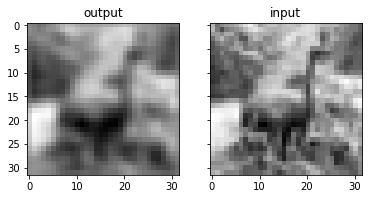

In [28]:
fig, axes = plt.subplots(1, 2, sharex='all', sharey='all')

axes[0].set_title('output')
axes[0].imshow(output[0, 0].detach(), cmap='gray')

axes[1].set_title('input')
axes[1].imshow(img.mean(0), cmap='gray')

In [24]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### 畳み込みを用いた特徴量の検出

In [25]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

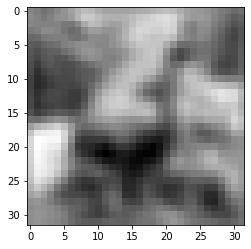

In [26]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

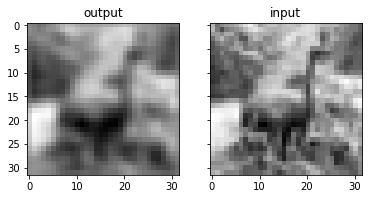

In [30]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
    ])
    conv.bias.zero_()
out = conv(img.unsqueeze(0))
    
fig, axes = plt.subplots(1, 2, sharex='all', sharey='all')

axes[0].set_title('output')
axes[0].imshow(output[0, 0].detach(), cmap='gray')

axes[1].set_title('input')
axes[1].imshow(img.mean(0), cmap='gray')

# 深さとプーリングの詳細

In [31]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

/home/takakiyuto/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ...
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
   
)

# nn.Moduleを継承したモデルの構築方法

In [36]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def foward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()

In [37]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
model(img.unsqueeze(0))

tensor([[0.1867, 0.1021]], grad_fn=<AddmmBackward>)

In [38]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch:{epoch} Training loss:{loss_train / len(train_loader)}')

In [42]:
train_loader = \
    torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2021-09-11 15:41:32.518031 Epoch:1 Training loss:0.5594199601632015
2021-09-11 15:41:37.848277 Epoch:10 Training loss:0.326911591895067
2021-09-11 15:41:43.626300 Epoch:20 Training loss:0.2973861292858792
2021-09-11 15:41:49.349453 Epoch:30 Training loss:0.26871143447555557
2021-09-11 15:41:55.096020 Epoch:40 Training loss:0.24496800257901477
2021-09-11 15:42:00.799045 Epoch:50 Training loss:0.22343783697504907
2021-09-11 15:42:06.489823 Epoch:60 Training loss:0.20532057201786405
2021-09-11 15:42:12.270290 Epoch:70 Training loss:0.1885204109226822
2021-09-11 15:42:18.293543 Epoch:80 Training loss:0.17585693788566406
2021-09-11 15:42:24.200561 Epoch:90 Training loss:0.16240367566229433
2021-09-11 15:42:30.141586 Epoch:100 Training loss:0.14868802703015363


In [43]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)


Accuracy train: 0.94
Accuracy val: 0.89


### モデルの保存と読み込み

In [44]:
# torch.save(model.state_dict(), '.')
# loaded_model = Net()
# loaded_model.load_state_dict(torch.load('.'))

In [45]:
device = ( torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'My device is {device}')

My device is cuda


In [46]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f'{datetime.datetime.now()} Epoch:{epoch} Training loss:{loss_train / len(train_loader)}')

In [47]:
train_loader = \
    torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2021-09-11 15:53:24.742904 Epoch:1 Training loss:0.5894205293078332
2021-09-11 15:53:26.470644 Epoch:10 Training loss:0.34183576987807157
2021-09-11 15:53:28.400637 Epoch:20 Training loss:0.30403258903011393
2021-09-11 15:53:30.346150 Epoch:30 Training loss:0.2757378951379448
2021-09-11 15:53:32.266400 Epoch:40 Training loss:0.25775556441894765
2021-09-11 15:53:34.212446 Epoch:50 Training loss:0.2376877579624486
2021-09-11 15:53:36.163850 Epoch:60 Training loss:0.2206636991375571
2021-09-11 15:53:38.085423 Epoch:70 Training loss:0.20521743035620185
2021-09-11 15:53:40.049732 Epoch:80 Training loss:0.18929364935607668
2021-09-11 15:53:42.022920 Epoch:90 Training loss:0.17344879285450193
2021-09-11 15:53:43.989137 Epoch:100 Training loss:0.15951902813212887


# 複雑なモデルの作り方

#### Not Hard Coding

In [50]:
import torch.nn.functional as F

class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*(n_chans1//2))
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = NetWidth()

sum(p.numel() for p in model.parameters())

38386

In [62]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                       train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} epoch:{} traing_loss:{}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [63]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [64]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

validate(model, train_loader, val_loader)

2021-09-11 17:57:23.175590 epoch:1 traing_loss:0.6007275467465638
2021-09-11 17:57:25.615548 epoch:10 traing_loss:0.3577278071338204
2021-09-11 17:57:28.322294 epoch:20 traing_loss:0.31634325975445426
2021-09-11 17:57:31.004577 epoch:30 traing_loss:0.2920622362452707
2021-09-11 17:57:33.722083 epoch:40 traing_loss:0.2752203892940169
2021-09-11 17:57:36.484701 epoch:50 traing_loss:0.2609564902106668
2021-09-11 17:57:39.207807 epoch:60 traing_loss:0.24837134104625436
2021-09-11 17:57:41.944228 epoch:70 traing_loss:0.23716671817052137
2021-09-11 17:57:44.682719 epoch:80 traing_loss:0.22701346228836447
2021-09-11 17:57:47.398975 epoch:90 traing_loss:0.2174269067254036
2021-09-11 17:57:50.132966 epoch:100 traing_loss:0.20837268423122965
Accuracy train: 0.93
Accuracy val: 0.89


{'train': 0.9296, 'val': 0.891}

In [66]:
import torch.nn.functional as F

class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8*8*(self.n_chans1//2))
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = NetDropout().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2021-09-11 18:14:18.094408 Epoch:1 Training loss:0.5873288386946272
2021-09-11 18:14:20.182227 Epoch:10 Training loss:0.3828128615192547
2021-09-11 18:14:22.504253 Epoch:20 Training loss:0.3502990655648481
2021-09-11 18:14:24.862107 Epoch:30 Training loss:0.32944151018835177
2021-09-11 18:14:27.298335 Epoch:40 Training loss:0.31605550390519915
2021-09-11 18:14:29.663508 Epoch:50 Training loss:0.2992375077335698
2021-09-11 18:14:32.027056 Epoch:60 Training loss:0.2810050861281195
2021-09-11 18:14:34.363624 Epoch:70 Training loss:0.27466663917538464
2021-09-11 18:14:36.692403 Epoch:80 Training loss:0.2563551850379652
2021-09-11 18:14:39.015191 Epoch:90 Training loss:0.2516549950002865
2021-09-11 18:14:41.337349 Epoch:100 Training loss:0.2409030780860573
Accuracy train: 0.90
Accuracy val: 0.88


{'train': 0.9014, 'val': 0.881}

In [69]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = NetBatchNorm().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2021-09-11 19:12:36.998016 Epoch:1 Training loss:0.43732480809187435
2021-09-11 19:12:39.409113 Epoch:10 Training loss:0.2718054237449245
2021-09-11 19:12:42.083174 Epoch:20 Training loss:0.2075935203083761
2021-09-11 19:12:44.811678 Epoch:30 Training loss:0.15463432121523626
2021-09-11 19:12:47.498333 Epoch:40 Training loss:0.10995554971467157
2021-09-11 19:12:50.203976 Epoch:50 Training loss:0.0727486589887909
2021-09-11 19:12:52.901878 Epoch:60 Training loss:0.04611814921354033
2021-09-11 19:12:55.583401 Epoch:70 Training loss:0.030036379915371444
2021-09-11 19:12:58.245852 Epoch:80 Training loss:0.01904534883678529
2021-09-11 19:13:00.929898 Epoch:90 Training loss:0.011827063660736487
2021-09-11 19:13:03.610620 Epoch:100 Training loss:0.007807591434710535
Accuracy train: 0.99
Accuracy val: 0.88


{'train': 0.9876, 'val': 0.8765}

### 複雑な構造体を学習するためにより深く：深さ

In [70]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [71]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [72]:
model = NetRes().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2021-09-11 19:17:44.653799 Epoch:1 Training loss:0.6116384047611504
2021-09-11 19:17:46.936711 Epoch:10 Training loss:0.3229008746944415
2021-09-11 19:17:49.476489 Epoch:20 Training loss:0.28226927150586606
2021-09-11 19:17:52.014635 Epoch:30 Training loss:0.24881000551068858
2021-09-11 19:17:54.555237 Epoch:40 Training loss:0.22293536711460465
2021-09-11 19:17:57.087289 Epoch:50 Training loss:0.19957167579300084
2021-09-11 19:17:59.604232 Epoch:60 Training loss:0.17581831701811712
2021-09-11 19:18:02.118089 Epoch:70 Training loss:0.15098332955389265
2021-09-11 19:18:04.622451 Epoch:80 Training loss:0.12617993993079588
2021-09-11 19:18:07.118010 Epoch:90 Training loss:0.10363955553739694
2021-09-11 19:18:09.630207 Epoch:100 Training loss:0.09222385184068209
Accuracy train: 0.97
Accuracy val: 0.89


{'train': 0.9656, 'val': 0.8885}